In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import  DecisionTreeClassifier,export_graphviz
from xgboost import plot_importance
from matplotlib import pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

## 进行模型训练，筛选出对目标列比较有影响的数据列

In [14]:
gc = pd.read_csv("gc.csv")
y =gc['emd_lable2']
x = gc
x = x.drop(['emd_lable2'],axis=1)

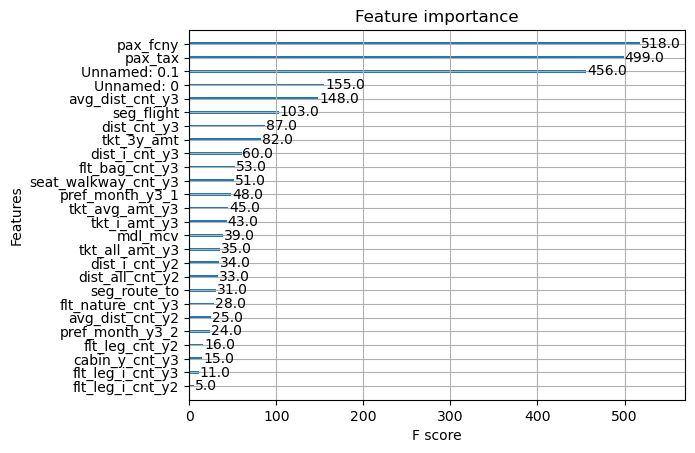

In [24]:
import xgboost as xgb
# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
#random_state是随机种子，是在任意带有随机性的类或函数里作为参数来控制随机模式
#train_test_split是随机数种子控制每次划分训练集和测试集的模式
X_train.to_csv("D:/XGboost/X_train.csv")
y_train.to_csv("D:/XGboost/y_train.csv")
X_test.to_csv("D:/XGboost/x_test.csv")
y_test.to_csv("D:/XGboost/y_test.csv")
model = xgb.XGBRegressor(objective='binary:logistic')
#objective表示损失函数的类型，分类预测使用binary:logistic（二分类时使用的逻辑回归问题，输出为概率）
model.fit(X_train, y_train)

# 对测试集进行预测
ans = model.predict(X_test)

# 显示重要特征
plot_importance(model)
plt.show()

In [16]:
gc1=gc.loc[0:,['pax_tax','pax_fcny','avg_dist_cnt_y3','seg_flight','tkt_3y_amt','dist_cnt_y3','seat_walkway_cnt_y3','dist_i_cnt_y3','tkt_avg_amt_y3','emd_lable2']]
gc1.to_csv("D:/XGboost/gc1.csv")
gc1

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2
0,0.000809,0.000596,0.000000,0.3750,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
1,0.000344,0.000392,0.347172,0.3750,0.001236,0.000000,0.000000,0.000000,0.024350,0.0
2,0.000417,0.000057,0.000000,0.5625,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
3,0.000629,0.000319,0.754508,0.5625,0.007383,0.030705,0.006993,0.030705,0.024350,0.0
4,0.000393,0.000158,0.000000,0.6250,0.007466,0.040664,0.017483,0.040664,0.012203,1.0
...,...,...,...,...,...,...,...,...,...,...
43909,0.000415,0.000098,0.411954,0.6250,0.001236,0.000000,0.000000,0.000000,0.021259,1.0
43910,0.000628,0.000166,0.700813,0.6250,0.008580,0.057040,0.006993,0.055707,0.024350,1.0
43911,0.000365,0.000040,0.000000,0.5000,0.001236,0.000000,0.000000,0.000000,0.012203,1.0
43912,0.000629,0.000178,0.000000,0.3750,0.008580,0.075018,0.006993,0.075018,0.012203,1.0


In [25]:
ts1 = pd.read_csv("ts1.csv")
ts = pd.read_csv("ts.csv")
ts2=ts1.loc[0:,['pax_tax','pax_fcny','avg_dist_cnt_y3','seg_flight','tkt_3y_amt','dist_cnt_y3','seat_walkway_cnt_y3','dist_i_cnt_y3','tkt_avg_amt_y3']]
ts2['emd_lable2']=ts['emd_lable2']
ts2['pax_name']=ts['pax_name']
ts2.to_csv("D:/XGboost/ts2.csv")
ts2

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2,pax_name
0,0.000315,0.000079,0.393975,0.6250,0.001236,0.00000,0.000000,0.00000,0.024350,0.0,21f0b1c838160ac26cb2c57660bc3fd5
1,0.000346,0.000060,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,21e0621a85f6db6139ff7cf2d53b4e5d
2,0.000569,0.000112,0.609106,0.6250,0.001236,0.00000,0.000000,0.00000,0.017461,0.0,197b215b23a93b19f391c422eb27f310
3,0.000791,0.000094,0.000000,0.5625,0.004045,0.04216,0.017483,0.04216,0.012203,0.0,92b435f20c6ce2fd5acef7b6ff49b6d0
4,0.000387,0.000117,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,a38ac8bfe0feb14c0469e2917bc74a05
...,...,...,...,...,...,...,...,...,...,...,...
6766,0.000705,0.000596,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,d6364954adcfbd58d8beebd686a9fbdc
6767,0.001018,0.000596,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,150b405be4282907eb7e87f992856ea1
6768,0.000381,0.000076,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,33b02fadd0d05938b8cc3dfbc735fd10
6769,0.000391,0.000090,0.000000,0.6250,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,29cb3dea4ecce778096484ff2e097f5b


## 查看训练集和验证集的列情况

In [18]:
gc1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43914 entries, 0 to 43913
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pax_tax              43914 non-null  float64
 1   pax_fcny             43914 non-null  float64
 2   avg_dist_cnt_y3      43914 non-null  float64
 3   seg_flight           43914 non-null  float64
 4   tkt_3y_amt           43914 non-null  float64
 5   dist_cnt_y3          43914 non-null  float64
 6   seat_walkway_cnt_y3  43914 non-null  float64
 7   dist_i_cnt_y3        43914 non-null  float64
 8   tkt_avg_amt_y3       43914 non-null  float64
 9   emd_lable2           43914 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


C:\Users\yaokexin\AppData\Local\Temp\ipykernel_6564\2352315568.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  gc1.info(verbose=True,null_counts=True)


In [26]:
ts2.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771 entries, 0 to 6770
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pax_tax              6771 non-null   float64
 1   pax_fcny             6771 non-null   float64
 2   avg_dist_cnt_y3      6771 non-null   float64
 3   seg_flight           6771 non-null   float64
 4   tkt_3y_amt           6771 non-null   float64
 5   dist_cnt_y3          6771 non-null   float64
 6   seat_walkway_cnt_y3  6771 non-null   float64
 7   dist_i_cnt_y3        6771 non-null   float64
 8   tkt_avg_amt_y3       6771 non-null   float64
 9   emd_lable2           6771 non-null   float64
 10  pax_name             6771 non-null   object 
dtypes: float64(10), object(1)
memory usage: 582.0+ KB


C:\Users\yaokexin\AppData\Local\Temp\ipykernel_6564\3820742093.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ts2.info(verbose=True,null_counts=True)


## 查看处理完的训练集以及验证集

In [20]:
gc1.head()

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2
0,0.000809,0.000596,0.000000,0.3750,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
1,0.000344,0.000392,0.347172,0.3750,0.001236,0.000000,0.000000,0.000000,0.024350,0.0
2,0.000417,0.000057,0.000000,0.5625,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
3,0.000629,0.000319,0.754508,0.5625,0.007383,0.030705,0.006993,0.030705,0.024350,0.0
4,0.000393,0.000158,0.000000,0.6250,0.007466,0.040664,0.017483,0.040664,0.012203,1.0


In [27]:
ts2.head()

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2,pax_name
0,0.000315,0.000079,0.393975,0.6250,0.001236,0.00000,0.000000,0.00000,0.024350,0.0,21f0b1c838160ac26cb2c57660bc3fd5
1,0.000346,0.000060,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,21e0621a85f6db6139ff7cf2d53b4e5d
2,0.000569,0.000112,0.609106,0.6250,0.001236,0.00000,0.000000,0.00000,0.017461,0.0,197b215b23a93b19f391c422eb27f310
3,0.000791,0.000094,0.000000,0.5625,0.004045,0.04216,0.017483,0.04216,0.012203,0.0,92b435f20c6ce2fd5acef7b6ff49b6d0
4,0.000387,0.000117,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,a38ac8bfe0feb14c0469e2917bc74a05
